## VAE-CTGAN 생성 데이터 Evaluation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler,OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


In [303]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTGAN/dataset/train_category.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTGAN/dataset/test_category.csv"
test_data = pd.read_csv(test_data_path)

## Load original data
fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN/Fake_Datasets/portfolios.csv"
fake = pd.read_csv(fake_path, low_memory=False)

In [205]:
fake['loan_amnt'].value_counts()

loan_amnt
9975.0     3958
10000.0    3938
9950.0     3657
1000.0     3641
10025.0    3329
           ... 
39900.0      26
39575.0      23
39975.0      23
39850.0      22
39725.0      21
Name: count, Length: 1483, dtype: int64

In [ ]:
"""# 데이터 타입 변환
fake['funded_amnt'] = pd.to_numeric(fake['funded_amnt'], errors='coerce')
fake['loan_amnt'] = pd.to_numeric(fake['loan_amnt'], errors='coerce')

# 0을 loan_amnt로 대체
mask = fake['funded_amnt'] == 0
fake.loc[mask, 'funded_amnt'] = fake.loc[mask, 'loan_amnt']

mask2 = fake['loan_amnt'] == 0
fake.loc[mask2, 'loan_amnt'] = fake.loc[mask2, 'funded_amnt']

# 여전히 0인 경우 확인
remaining = (fake['funded_amnt'] == 0).sum()
print(f"✅ 최종 funded_amnt == 0 개수: {remaining}")
"""

✅ 최종 funded_amnt == 0 개수: 202


In [ ]:
"""# 평균값 계산 (0이 아닌 값 기준)
mean_funded_amnt = fake.loc[fake['funded_amnt'] > 0, 'funded_amnt'].mean()

# 0인 값에 평균 대입
fake.loc[fake['funded_amnt'] == 0, 'funded_amnt'] = mean_funded_amnt

mask2 = fake['loan_amnt'] == 0
fake.loc[mask2, 'loan_amnt'] = fake.loc[mask2, 'funded_amnt']

print("✅ funded_amnt == 0 개수 (after fill):", (fake['loan_amnt'] == 0).sum())
"""

✅ funded_amnt == 0 개수 (after fill): 0


In [5]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540000 entries, 0 to 539999
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   last_fico_range_high  540000 non-null  int64  
 1   annual_inc            540000 non-null  float64
 2   dti                   540000 non-null  float64
 3   mo_sin_old_rev_tl_op  540000 non-null  float64
 4   revol_util            540000 non-null  float64
 5   int_rate              540000 non-null  float64
 6   installment           540000 non-null  float64
 7   avg_cur_bal           540000 non-null  float64
 8   revol_bal             540000 non-null  float64
 9   debt_settlement_flag  540000 non-null  object 
 10  sub_grade             540000 non-null  object 
 11  home_ownership        540000 non-null  object 
 12  purpose               540000 non-null  object 
 13  grade                 540000 non-null  object 
 14  total_pymnt           540000 non-null  float64
 15  

In [6]:
fake['loan_status'].value_counts()

loan_status
1    540000
Name: count, dtype: int64

In [92]:
"""fake['loan_status'] = 1
fake.columns"""

"fake['loan_status'] = 1\nfake.columns"

In [7]:
for col in data.columns:
    print(f"{col} feature\n{data[col].unique()}")

last_fico_range_high feature
[744. 739. 614. 604. 654. 804. 824. 659. 559. 724. 769. 589. 499. 694.
 584. 719. 689. 669. 779. 684. 674. 749. 649. 664. 734. 639. 634. 594.
 619. 544. 699. 679. 759. 729. 784. 709. 549. 629. 704. 564. 579. 529.
 569. 714. 754. 599. 764. 539. 574. 534. 519. 524. 644. 814. 609. 794.
 789. 829. 774. 799. 514. 819. 834. 509. 624. 839. 554. 809. 504. 844.
 850.   0.]
annual_inc feature
[50000.  60000.  75000.  ... 31235.  75388.  13235.5]
dti feature
[  4.66  16.14  24.67 ...  97.94  56.6  131.58]
mo_sin_old_rev_tl_op feature
[126.         151.         292.         206.         424.
 114.         308.         131.         275.         315.
 150.         365.         105.         333.         161.
 157.          95.         321.          81.         135.
 130.         117.         102.         223.         503.
 178.          56.         103.         199.         137.
 123.         138.          29.         189.         187.
  30.         118.         186.     

In [97]:
for col in fake.columns:
    print(f"{col} feature\n{fake[col].unique()}")

last_fico_range_high feature
[559 539 599 499 544 509 589 634 534 579 524 639 604 564 504 549 669 664
 574 644 674 654 554 514 584 614 624 649 609 629 594 569 619 709 529 659
 744 519 769 689 764 850 714 699 684 739 754 679 734 704 774 694 819 719
 779 809 799 724 794 749 729 824 814 759 804 829 789 834 839 784 844]
annual_inc feature
[ 57365.4 107498.   59025.  ...  17125.   64117.   27348. ]
dti feature
[29.88 32.87 20.47 ... 57.53 53.3  69.2 ]
mo_sin_old_rev_tl_op feature
[293.89299054 133.24538206 435.19384456 ... 159.56484452  74.44792114
 147.65605578]
revol_util feature
[0.207 0.353 0.389 ... 1.203 1.105 1.082]
int_rate feature
[0.1014 0.1485 0.1774 0.2528 0.2264 0.1158 0.0894 0.0881 0.2048 0.0662
 0.2606 0.0734 0.2122 0.1183 0.1891 0.2159 0.1824 0.2614 0.1446 0.1595
 0.1411 0.1269 0.1577 0.1398 0.0724 0.1046 0.1416 0.1449 0.1756 0.1347
 0.152  0.1862 0.0988 0.1966 0.247  0.1786 0.1839 0.0807 0.1948 0.1607
 0.1019 0.0849 0.0932 0.1496 0.1709 0.1527 0.1929 0.1989 0.1284 0.2215
 0

In [149]:
fake['term_months'].value_counts()

term_months
36    319041
60    220959
Name: count, dtype: int64

In [10]:
data.columns

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'grade', 'total_pymnt', 'total_pymnt_inv', 'funded_amnt', 'loan_amnt',
       'credit_history_years', 'term_months', 'loan_status'],
      dtype='object')

In [304]:
#keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
data_classification = data.copy()
test_classification = test_data.copy()
fake_classification = fake.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)
fake_classification = fake_classification.drop(columns = keep_features)

In [12]:
data_classification.columns

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'credit_history_years', 'term_months', 'loan_status'],
      dtype='object')

In [9]:
fake_classification.columns

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'credit_history_years', 'term_months', 'loan_status'],
      dtype='object')

In [305]:
## data Encoding
Labelencoding_features = ['term_months', 'sub_grade']
onehot_features = ['debt_settlement_flag', 'home_ownership', 'purpose']

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

label_encoders = {}
for col in Labelencoding_features:
    le = LabelEncoder()
    data_classification[col] = le.fit_transform(data_classification[col])
    label_encoders[col] = le

# One-Hot Encoding
onehot_encoded = onehot_encoder.fit_transform(data_classification[onehot_features])
onehot_encoded_df = pd.DataFrame(
    onehot_encoded, 
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=data_classification.index
)

# Merge
data_classification.drop(columns=onehot_features, inplace=True)
data_classification = pd.concat([data_classification, onehot_encoded_df], axis=1)

print("✅ Encoding 완료! 결과 shape:", data_classification.shape)

✅ Encoding 완료! 결과 shape: (1116458, 35)


In [306]:
##Fake data encoding
for col in Labelencoding_features:
    le = label_encoders[col]
    fake_classification[col] = le.transform(fake_classification[col])

# One-Hot Encoding (train에서 fit된 onehot_encoder 재사용)
onehot_encoded_test = onehot_encoder.transform(fake_classification[onehot_features])
onehot_encoded_test_df = pd.DataFrame(
    onehot_encoded_test,
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=fake_classification.index
)

# Merge
fake_classification.drop(columns=onehot_features, inplace=True)
fake_classification = pd.concat([fake_classification, onehot_encoded_test_df], axis=1)

print("✅ 테스트 데이터 인코딩 완료! 결과 shape:", fake_classification.shape)

##Test data encoding
for col in Labelencoding_features:
    le = label_encoders[col]
    test_classification[col] = le.transform(test_classification[col])

# One-Hot Encoding (train에서 fit된 onehot_encoder 재사용)
onehot_encoded_test = onehot_encoder.transform(test_classification[onehot_features])
onehot_encoded_test_df = pd.DataFrame(
    onehot_encoded_test,
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=test_classification.index
)

# Merge
test_classification.drop(columns=onehot_features, inplace=True)
test_classification = pd.concat([test_classification, onehot_encoded_test_df], axis=1)

print("✅ 테스트 데이터 인코딩 완료! 결과 shape:", test_classification.shape)

✅ 테스트 데이터 인코딩 완료! 결과 shape: (540000, 35)
✅ 테스트 데이터 인코딩 완료! 결과 shape: (744306, 35)


In [307]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, train_size=0.8, test_size=0.2, random_state=42, stratify=data_y)

train_classification = pd.concat([X_train, y_train], axis=1)

In [308]:
from sklearn.utils import shuffle

train_data = pd.concat([train_classification, fake_classification])
train_data['loan_status'].value_counts()
train_data = shuffle(train_data, random_state=42)

In [18]:
train_data['loan_status'].value_counts()

loan_status
0    718935
1    714231
Name: count, dtype: int64

In [309]:
X_train = train_data.drop(columns='loan_status')
y_train = train_data[['loan_status']]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification[['loan_status']]

In [310]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

model = XGBClassifier( 
    n_estimators=500,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.68622	validation_1-logloss:0.68434
[1]	validation_0-logloss:0.67944	validation_1-logloss:0.67767
[2]	validation_0-logloss:0.67281	validation_1-logloss:0.67113
[3]	validation_0-logloss:0.66628	validation_1-logloss:0.66472
[4]	validation_0-logloss:0.65990	validation_1-logloss:0.65843
[5]	validation_0-logloss:0.65362	validation_1-logloss:0.65227
[6]	validation_0-logloss:0.64748	validation_1-logloss:0.64624
[7]	validation_0-logloss:0.64144	validation_1-logloss:0.64031
[8]	validation_0-logloss:0.63553	validation_1-logloss:0.63450
[9]	validation_0-logloss:0.62972	validation_1-logloss:0.62881
[10]	validation_0-logloss:0.62402	validation_1-logloss:0.62322
[11]	validation_0-logloss:0.61843	validation_1-logloss:0.61773
[12]	validation_0-logloss:0.61294	validation_1-logloss:0.61235
[13]	validation_0-logloss:0.60754	validation_1-logloss:0.60707
[14]	validation_0-logloss:0.60225	validation_1-logloss:0.60189
[15]	validation_0-logloss:0.59705	validation_1-logloss:0.59680
[1

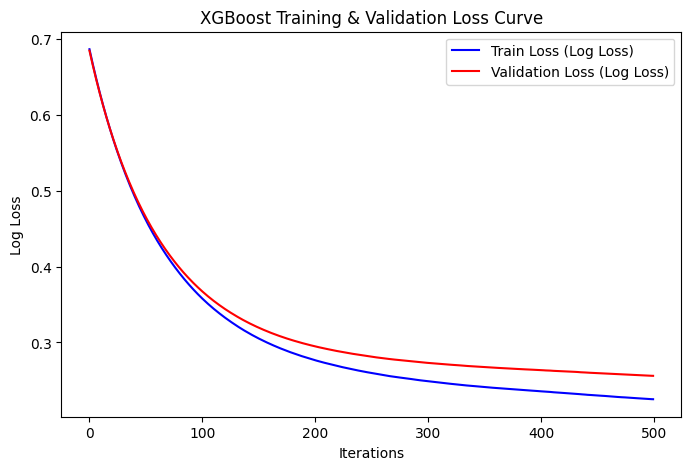

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93    599114
           1       0.66      0.90      0.76    145192

    accuracy                           0.89    744306
   macro avg       0.81      0.89      0.84    744306
weighted avg       0.91      0.89      0.89    744306



In [311]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [312]:
from sklearn.metrics import confusion_matrix
# confusion matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 행: 실제값 (y_test), 열: 예측값 (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("✅ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

✅ Confusion Matrix
[[530971  68143]
 [ 14887 130305]]

True Positives (TP): 130305
False Positives (FP): 68143
True Negatives (TN): 530971
False Negatives (FN): 14887


## VAE-CTGAN 생성 데이터 Portfolio

In [313]:
def encode_features(df, label_encoders, onehot_encoder, label_cols, onehot_cols):
    df = df.copy()
    
    # Label Encoding
    for col in label_cols:
        le = label_encoders[col]
        df[col] = le.transform(df[col])

    # One-Hot Encoding
    onehot_encoded = onehot_encoder.transform(df[onehot_cols])
    onehot_df = pd.DataFrame(
        onehot_encoded, 
        columns=onehot_encoder.get_feature_names_out(onehot_cols),
        index=df.index
    )

    df.drop(columns=onehot_cols, inplace=True)
    df = pd.concat([df, onehot_df], axis=1)
    
    return df

In [289]:
summary_with_sharpe = []

def linear_portfolio(top_10_indices):
    selected = test_data.loc[top_10_indices.index].copy()
    returns = (selected['total_pymnt_inv'] - selected['funded_amnt']) / selected['funded_amnt']
    
    avg_return = returns.mean()
    std_return = returns.std()
    sharpe_ratio = avg_return / std_return if std_return != 0 else np.nan

    summary_with_sharpe.append({
        'Average Return': avg_return * 100,
        'Std Dev': std_return,
        'Sharpe Ratio': sharpe_ratio
    }) 

In [31]:
data.columns

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'grade', 'total_pymnt', 'total_pymnt_inv', 'funded_amnt', 'loan_amnt',
       'credit_history_years', 'term_months', 'loan_status'],
      dtype='object')

In [314]:
#from sklearn.linear_model import HuberRegressor

drop2 = ['loan_status', 'return']

scaler = StandardScaler()
reg = LinearRegression()
#reg = HuberRegressor()

fully_paid_indices = (y_pred == 0)
test_regression = test_data[fully_paid_indices]
test_regression['return'] = (test_regression['total_pymnt_inv'] - test_regression['funded_amnt'])/(test_regression['funded_amnt']+1e-8)

train_regression = data.copy()
train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']

drop_features = ['loan_status', 'total_pymnt_inv', 'total_pymnt','funded_amnt','grade','loan_amnt']
train_regression = train_regression.drop(columns=drop_features)
test_regression = test_regression.drop(columns=drop_features)

fake_regression = fake.copy()
fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
fake_regression = fake_regression.drop(columns=drop_features)

train_total_reg = pd.concat([train_regression, fake_regression])

########## Encoding categorical data ######################
train_total_reg = encode_features(train_total_reg, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

data_x_reg = train_total_reg.drop(columns='return')
data_y_reg = train_total_reg[['return']]

test_x = test_regression.drop(columns = 'return')
test_y = test_regression[['return']]

data_x_reg_scaled = scaler.fit_transform(data_x_reg)

X_train_reg = data_x_reg_scaled
y_train_reg = data_y_reg

test_x_scaled = scaler.transform(test_x)

reg.fit(X_train_reg, y_train_reg)

#print(reg.coef_)
y_pred_reg = reg.predict(test_x_scaled)

print("RMSE:", mean_squared_error(test_y, y_pred_reg, squared=False))
print("R²:", r2_score(test_y, y_pred_reg))

test_regression['predicted_return'] = reg.predict(test_x_scaled)

"""# y_pred가 0인 Fully Paid 대상 중
# 상위 10% 수익률이지만 std 너무 큰 예측은 제외
top_10 = test_regression[test_regression['predicted_return'] >= test_regression['predicted_return'].quantile(0.99)]

# 예측 수익률이 너무 극단적인 애들 제거 (예: > Q99.5)
max_threshold = test_regression['predicted_return'].quantile(0.995)
top_10 = top_10[top_10['predicted_return'] <= max_threshold]
top_10_percent = top_10.sort_values(by='predicted_return', ascending=False).head(int(len(top_10)*0.1))"""
top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

linear_portfolio(top_10_percent)

RMSE: 0.17635768905462423
R²: -0.17601695301744003


In [133]:
y_pred_reg

array([[ 0.07019481],
       [ 0.22223339],
       [-0.01833764],
       ...,
       [ 0.12488517],
       [ 0.33067951],
       [-0.01707974]])

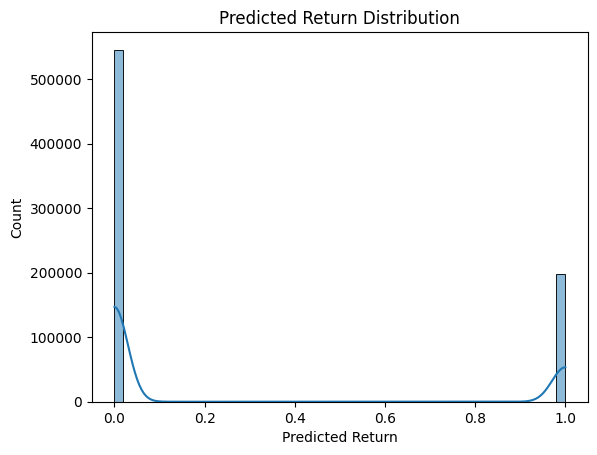

y_pred std: 0.44219281644251446


In [176]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(y_pred, bins=50, kde=True)
plt.title("Predicted Return Distribution")
plt.xlabel("Predicted Return")
plt.show()

print("y_pred std:", np.std(y_pred))

In [315]:
returns_with_sharpe_df = pd.DataFrame(summary_with_sharpe)

returns_with_sharpe_df.head()

,Average Return,Std Dev,Sharpe Ratio
0,18.417088,0.133123,1.383461
1,19.513351,0.154177,1.265648
2,16.176589,0.124784,1.296368
3,16.712862,0.130683,1.278888


In [296]:
selected = test_data.loc[top_10_percent.index].copy()

In [71]:
data_label0 = data[data['loan_status'] == 0]

data_label0.head(10)

,last_fico_range_high,annual_inc,dti,mo_sin_old_rev_tl_op,revol_util,int_rate,installment,avg_cur_bal,revol_bal,debt_settlement_flag,...,home_ownership,purpose,grade,total_pymnt,total_pymnt_inv,funded_amnt,loan_amnt,credit_history_years,term_months,loan_status
0,744.0,50000.0,4.66,126.0,0.768,0.0917,140.27,64898.0,5913.0,N,...,OWN,home_improvement,B,5047.683237,5047.68,4400.0,4400.0,11,36,0
1,739.0,60000.0,16.14,151.0,0.865,0.1249,568.64,1831.0,23949.0,N,...,RENT,debt_consolidation,B,20441.120277,20441.12,17000.0,17000.0,12,36,0
2,614.0,75000.0,24.67,292.0,0.858,0.0819,244.41,19333.0,17425.0,N,...,MORTGAGE,debt_consolidation,A,12559.080000,12559.08,12000.0,12000.0,24,60,0
4,654.0,70000.0,23.70,424.0,0.847,0.1199,332.10,25393.0,19249.0,N,...,MORTGAGE,small_business,B,11948.739214,11769.51,10000.0,10000.0,36,36,0
5,804.0,85000.0,12.42,114.0,0.341,0.1368,680.45,3107.0,15115.0,N,...,MORTGAGE,debt_consolidation,C,22382.302587,22382.30,20000.0,20000.0,10,36,0
6,824.0,120000.0,19.63,308.0,0.052,0.0532,150.58,25396.0,4612.0,N,...,MORTGAGE,debt_consolidation,A,5419.162725,5419.16,5000.0,5000.0,26,36,0
7,739.0,125000.0,6.56,131.0,0.420,0.0899,190.78,32949.0,8403.0,N,...,MORTGAGE,home_improvement,B,6861.697973,6861.70,6000.0,6000.0,12,36,0
8,659.0,38000.0,18.70,275.0,0.498,0.2185,275.34,1326.0,2938.0,N,...,RENT,debt_consolidation,D,12964.445362,12964.45,10000.0,10000.0,23,60,0
10,724.0,100000.0,15.32,150.0,0.658,0.1499,173.31,36504.0,1907.0,N,...,RENT,other,C,5293.631026,5293.63,5000.0,5000.0,14,36,0
11,769.0,50000.0,9.77,365.0,0.075,0.0649,674.18,11731.0,5946.0,N,...,MORTGAGE,debt_consolidation,A,24262.468080,24262.47,22000.0,22000.0,30,36,0


In [70]:
selected.head(10)

,last_fico_range_high,annual_inc,dti,mo_sin_old_rev_tl_op,revol_util,int_rate,installment,avg_cur_bal,revol_bal,debt_settlement_flag,...,home_ownership,purpose,grade,total_pymnt,total_pymnt_inv,funded_amnt,loan_amnt,credit_history_years,term_months,loan_status
302472,654.0,400000.0,24.83,200.0,0.374,0.1655,1240.03,555925.0,2904836.0,N,...,OWN,moving,D,44558.499846,44558.50,35000.0,35000.0,19,36,0
518695,744.0,999999.0,13.30,334.0,0.163,0.0769,817.28,240050.0,2560703.0,N,...,MORTGAGE,debt_consolidation,A,29421.720822,29421.72,26200.0,26200.0,28,36,0
252198,659.0,45000.0,14.67,186.0,8.923,0.1249,117.08,2834.0,2677.0,N,...,RENT,debt_consolidation,B,3944.660000,3944.66,3500.0,3500.0,16,36,0
220926,709.0,575000.0,32.35,309.0,0.330,0.2388,822.57,243435.0,1696796.0,N,...,MORTGAGE,credit_card,E,22723.016183,22723.02,21000.0,21000.0,26,36,0
588500,804.0,350000.0,10.86,194.0,0.980,0.1279,428.31,77110.0,762675.0,N,...,MORTGAGE,home_improvement,C,15410.072617,15047.48,12750.0,12750.0,16,36,0
469397,794.0,600000.0,23.44,248.0,0.394,0.0824,1100.66,121597.0,1039013.0,N,...,MORTGAGE,home_improvement,B,36580.448373,36580.45,35000.0,35000.0,21,36,0
461950,769.0,350000.0,30.32,368.0,0.445,0.1041,973.81,58650.0,1113293.0,N,...,MORTGAGE,credit_card,B,32914.160871,32914.16,30000.0,30000.0,31,36,0
739407,764.0,300000.0,26.70,255.0,0.349,0.1646,982.53,130259.0,1137891.0,N,...,MORTGAGE,home_improvement,C,47420.041335,47420.04,40000.0,40000.0,21,60,0
302146,764.0,280000.0,37.62,551.0,0.841,0.2250,305.68,82415.0,827165.0,N,...,MORTGAGE,debt_consolidation,D,8655.450929,8655.45,7950.0,7950.0,46,36,0
739308,709.0,97000.0,37.89,118.0,0.909,0.1899,476.47,86237.0,959754.0,N,...,MORTGAGE,other,D,15508.273273,15508.27,13000.0,13000.0,16,36,0


In [297]:
# 조건을 만족하는 행 필터링
underwater_loans = selected[selected['total_pymnt_inv'] < selected['funded_amnt']]

# 결과 출력
print("총 개수:", len(underwater_loans))
print(underwater_loans[['funded_amnt', 'total_pymnt_inv']].head())


총 개수: 366
        funded_amnt  total_pymnt_inv
472200       9000.0             0.00
87225       26750.0          4819.30
80825        7000.0          1865.42
35047       12500.0         11132.63
54396       10325.0          3611.62


In [256]:
original_top = selected
original_top['return'] = (original_top['total_pymnt_inv'] - original_top['funded_amnt'])/original_top['funded_amnt']
print(f"Average Return : {original_top['return'].mean()}, std : {original_top['return'].std()}, Sharpe (Before Filtering):", original_top['return'].mean() / original_top['return'].std())

# 손실인 애들 제거
filtered_top = original_top[original_top['total_pymnt_inv'] >= original_top['funded_amnt']]
print(f"Average Return : {filtered_top['return'].mean()}, std : {filtered_top['return'].std()}, Sharpe (After Filtering):", filtered_top['return'].mean() / filtered_top['return'].std())


Average Return : 0.1617658879807491, std : 0.12478397202082397, Sharpe (Before Filtering): 1.2963675170858768
Average Return : 0.16628118413855464, std : 0.10895878643093547, Sharpe (After Filtering): 1.526092475744978


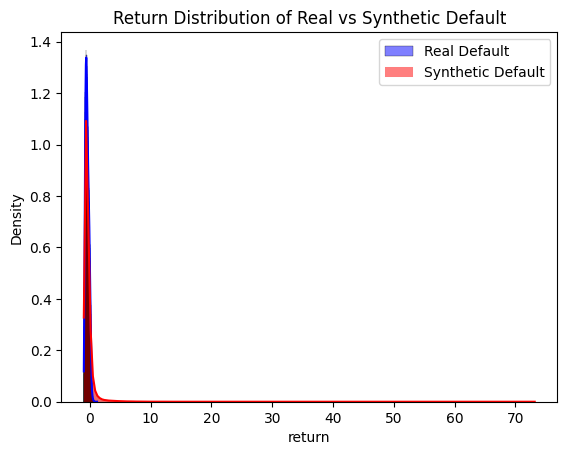

In [79]:
# 히스토그램 비교
original_default = data[data['loan_status'] == 1]
original_default['return'] = (original_default['total_pymnt_inv'] - original_default['funded_amnt'])/original_default['funded_amnt']
sns.histplot(original_default['return'], color='blue', label='Real Default', stat='density', kde=True)
sns.histplot(fake_regression['return'], color='red', label='Synthetic Default', stat='density', kde=True)
plt.legend()
plt.title("Return Distribution of Real vs Synthetic Default")
plt.show()


In [257]:
# 수익률 계산 (혹시 아직 안 되어 있다면)
original_default['return'] = (
    original_default['total_pymnt_inv'] - original_default['funded_amnt']
) / (original_default['funded_amnt'] + 1e-8)

# 최소값과 최대값 출력
min_return = original_default['return'].min()
max_return = original_default['return'].max()

print(f"✅ Original Default 수익률 범위:\n최소: {min_return:.4f}\n최대: {max_return:.4f}")


✅ Original Default 수익률 범위:
최소: -1.0000
최대: 1.1703


In [298]:
## 수익률이 5%이상 받은 샘플 확인
# 수익률 500% 이하인 샘플 필터링
filtered_samples = fake[fake['total_pymnt_inv'] / (fake['funded_amnt']) <= 100]

filtered_samples['return'] = (
    filtered_samples['total_pymnt_inv'] - filtered_samples['funded_amnt']
) / (filtered_samples['funded_amnt'])

# 수익률 높은 순으로 확인
filtered_samples_sorted = filtered_samples.sort_values(by='return', ascending=False)

num_above_max = (filtered_samples_sorted['return'] > 1.17).sum()

print(f"✅ 수익률이 1.17보다 높은 합성 샘플 수: {num_above_max}")
# 상위 5개 예시 확인
print(filtered_samples_sorted[['funded_amnt', 'total_pymnt_inv', 'return']].head())


✅ 수익률이 1.17보다 높은 합성 샘플 수: 16584
        funded_amnt  total_pymnt_inv     return
376617       1000.0     74171.408047  73.171408
417757       1000.0     74171.408047  73.171408
22561        1000.0     74171.408047  73.171408
478060       1000.0     68860.395875  67.860396
62512        1000.0     50599.506122  49.599506


In [299]:
filtered_samples_sorted[['funded_amnt', 'loan_amnt','total_pymnt','total_pymnt_inv', 'return']].head(10)

,funded_amnt,loan_amnt,total_pymnt,total_pymnt_inv,return
376617,1000.0,4775.0,1631.972298,74171.408047,73.171408
417757,1000.0,3575.0,712.776418,74171.408047,73.171408
22561,1000.0,4000.0,1034.527294,74171.408047,73.171408
478060,1000.0,5075.0,716.444641,68860.395875,67.860396
62512,1000.0,17550.0,24644.848246,50599.506122,49.599506
308333,1550.0,10050.0,5324.505743,74171.408047,46.852521
33939,1600.0,3700.0,246.967634,74171.408047,45.357130
254066,1725.0,10025.0,32448.831381,68571.437887,38.751558
314698,1000.0,17975.0,3741.563931,37826.036436,36.826036
120322,1650.0,3850.0,1571.215523,61010.978427,35.976351


In [300]:
target_idx = filtered_samples_sorted.index
fake_target = fake.loc[target_idx].copy()

"""fake_target['funded_amnt'] = fake_target[['funded_amnt', 'loan_amnt']].mean(axis=1)
fake_target['loan_amnt']   = fake_target['funded_amnt']"""

"""# 받은 돈은 높은 쪽을 유지
fake_target['total_pymnt']     = fake_target[['total_pymnt', 'total_pymnt_inv']].mean(axis=1)
fake_target['total_pymnt_inv'] = fake_target['total_pymnt']"""

# 수익률이 1.5 이상이면 total_pymnt_inv는 min값으로 강제
use_max = (fake_target['total_pymnt_inv'] - fake_target['funded_amnt']) / fake_target['funded_amnt'] <= 1.3

fake_target['total_pymnt'] = np.where(
    use_max,
    fake_target[['total_pymnt', 'total_pymnt_inv']].max(axis=1),
    fake_target[['total_pymnt', 'total_pymnt_inv']].min(axis=1)
)

fake_target['total_pymnt_inv'] = fake_target['total_pymnt']


fake_target['return'] = (
    fake_target['total_pymnt_inv'] - fake_target['funded_amnt']
) / (fake_target['funded_amnt'])

print(fake_target[['funded_amnt', 'loan_amnt', 'total_pymnt', 'total_pymnt_inv', 'return']].head())

        funded_amnt  loan_amnt   total_pymnt  total_pymnt_inv     return
376617       1000.0     4775.0   1631.972298      1631.972298   0.631972
417757       1000.0     3575.0    712.776418       712.776418  -0.287224
22561        1000.0     4000.0   1034.527294      1034.527294   0.034527
478060       1000.0     5075.0    716.444641       716.444641  -0.283555
62512        1000.0    17550.0  24644.848246     24644.848246  23.644848


In [91]:
"""# 후처리 대상 인덱스만 선택 (예: filtered_samples_sorted 기준)
target_idx = filtered_samples_sorted.index

# 원본 fake 데이터에서 해당 인덱스 추출
fake_target = fake.loc[target_idx].copy()

# ① funded_amnt와 loan_amnt는 큰 값으로 통일
fake_target['funded_amnt'] = fake_target[['funded_amnt', 'loan_amnt']].max(axis=1)
fake_target['loan_amnt']   = fake_target['funded_amnt']  # 동일하게 맞춤

# ② total_pymnt와 total_pymnt_inv는 작은 값으로 통일
fake_target['total_pymnt']     = fake_target[['total_pymnt', 'total_pymnt_inv']].min(axis=1)
fake_target['total_pymnt_inv'] = fake_target['total_pymnt']  # 동일하게 맞춤

# ③ 수익률 재계산
fake_target['return'] = (
    fake_target['total_pymnt_inv'] - fake_target['funded_amnt']
) / (fake_target['funded_amnt'] + 1e-8)

# 결과 확인
print(fake_target[['funded_amnt', 'loan_amnt', 'total_pymnt', 'total_pymnt_inv', 'return']].head())
"""

        funded_amnt  loan_amnt   total_pymnt  total_pymnt_inv    return
376617       4775.0     4775.0   1631.972298      1631.972298 -0.658226
417757       3575.0     3575.0    712.776418       712.776418 -0.800622
22561        4000.0     4000.0   1034.527294      1034.527294 -0.741368
478060       5075.0     5075.0    716.444641       716.444641 -0.858829
62512       17550.0    17550.0  24644.848246     24644.848246  0.404265


In [301]:
fake.update(fake_target)

In [94]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540000 entries, 0 to 539999
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   last_fico_range_high  540000 non-null  int64  
 1   annual_inc            540000 non-null  float64
 2   dti                   540000 non-null  float64
 3   mo_sin_old_rev_tl_op  540000 non-null  float64
 4   revol_util            540000 non-null  float64
 5   int_rate              540000 non-null  float64
 6   installment           540000 non-null  float64
 7   avg_cur_bal           540000 non-null  float64
 8   revol_bal             540000 non-null  float64
 9   debt_settlement_flag  540000 non-null  object 
 10  sub_grade             540000 non-null  object 
 11  home_ownership        540000 non-null  object 
 12  purpose               540000 non-null  object 
 13  grade                 540000 non-null  object 
 14  total_pymnt           540000 non-null  float64
 15  

In [302]:
output_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN/Fake_Datasets/portfolios.csv"
fake.to_csv(output_path, index=False)
print(f"✅ Final dataset saved to: {output_path}")

✅ Final dataset saved to: C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN/Fake_Datasets/portfolios.csv


## Analysis between Original and VAE-TableGAN Samples

In [202]:
label1_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTGAN/dataset/train_category_1.csv"
label1_data = pd.read_csv(label1_data_path, low_memory=False)

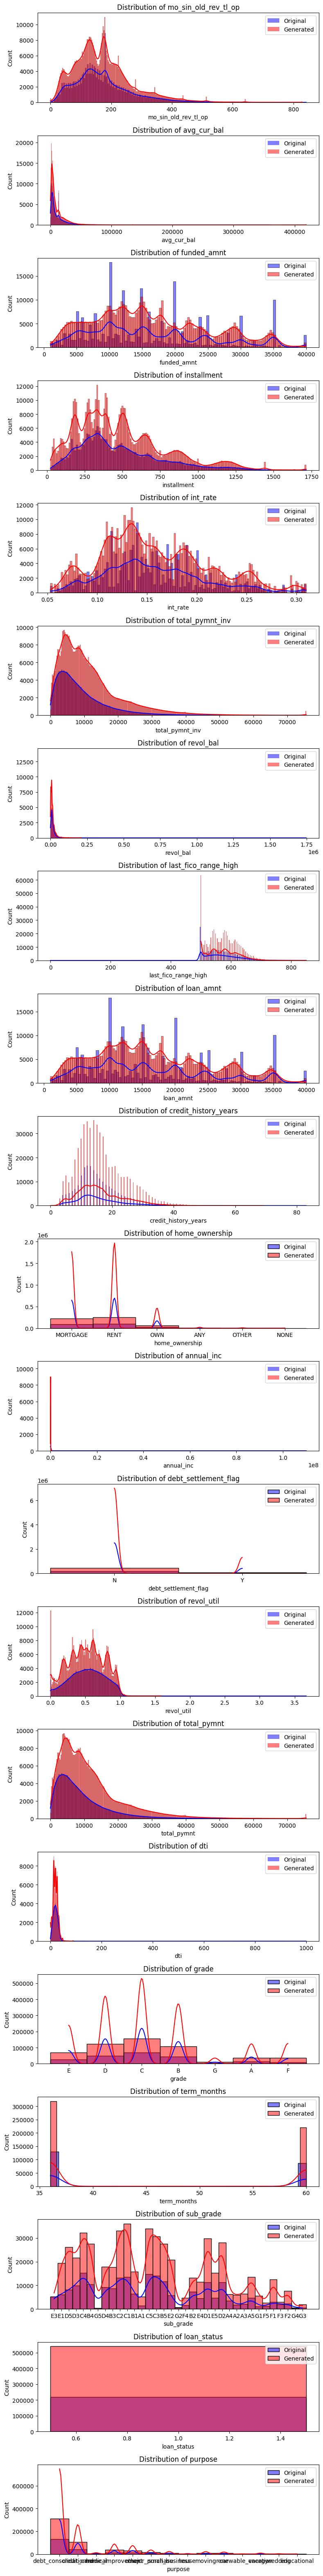

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 원본 데이터와 TableGAN 생성 데이터 불러오기
# 원본 데이터: original_df
# TableGAN이 생성한 데이터: generated_df

# 공통 feature 선택 (혹시 컬럼이 다를 수도 있으니)
common_features = list(set(data.columns) & set(fake.columns))
original_df = label1_data[common_features]
generated_df = fake[common_features]

# ------------------------------
# 1️⃣ 히스토그램 비교 (각 feature 분포)
# ------------------------------
num_features = len(common_features)
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(8, num_features * 3))

for i, feature in enumerate(common_features):
    sns.histplot(original_df[feature], color='blue', label='Original', kde=True, ax=axes[i], alpha=0.5)
    sns.histplot(generated_df[feature], color='red', label='Generated', kde=True, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [118]:
label1_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217789 entries, 0 to 217788
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   last_fico_range_high  217789 non-null  float64
 1   annual_inc            217789 non-null  float64
 2   dti                   217789 non-null  float64
 3   mo_sin_old_rev_tl_op  217789 non-null  float64
 4   revol_util            217789 non-null  float64
 5   int_rate              217789 non-null  float64
 6   installment           217789 non-null  float64
 7   avg_cur_bal           217789 non-null  float64
 8   revol_bal             217789 non-null  float64
 9   debt_settlement_flag  217789 non-null  object 
 10  sub_grade             217789 non-null  object 
 11  home_ownership        217789 non-null  object 
 12  purpose               217789 non-null  object 
 13  grade                 217789 non-null  object 
 14  total_pymnt           217789 non-null  float64
 15  

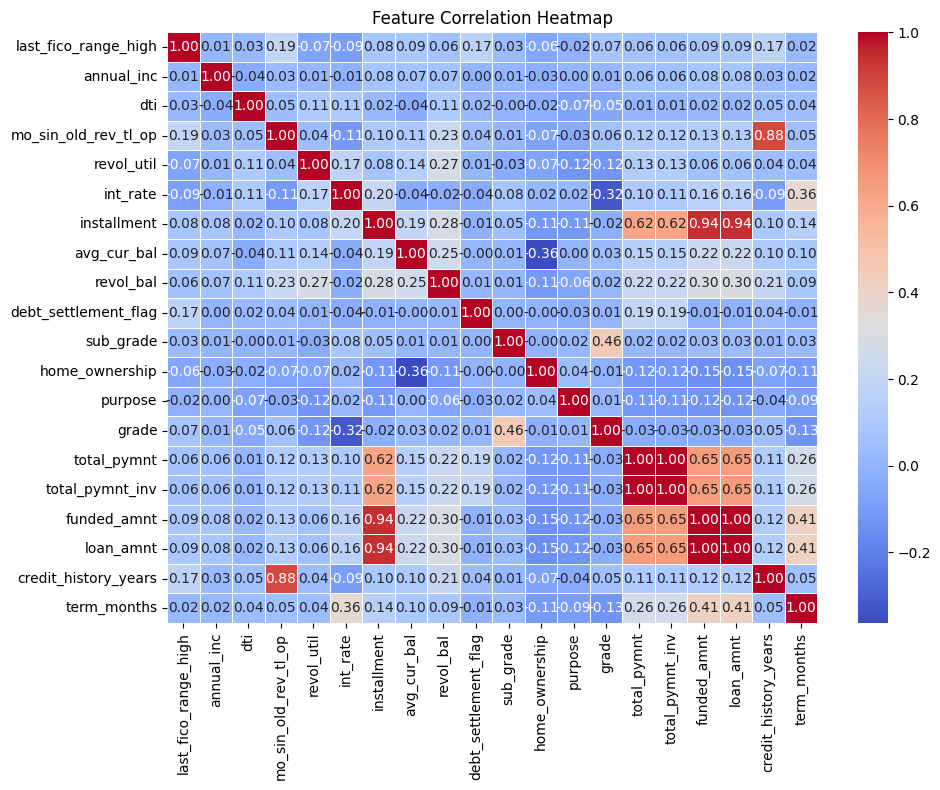

In [119]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = label1_data.copy()

if 'loan_status' in df.columns:
    df = df.drop(columns=['loan_status'])

# 문자열 → 숫자 변환 (필요시)
for col in df.select_dtypes(include='object').columns:
    df[col] = pd.factorize(df[col])[0]

corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()

plt.savefig("correlation_heatmap.png", dpi=300)

plt.show()


In [120]:
for col in data.columns:
    if pd.api.types.is_numeric_dtype(data[col]):
        zero_count = (data[col] == 0).sum()
        if zero_count > 0:
            print(f"🔴 Column '{col}' has {zero_count} zero values.")
        else:
            print(f"✅ Column '{col}' has no zero values.")
    else:
        print(f"ℹ️ Column '{col}' is not numeric, skipped.")


🔴 Column 'last_fico_range_high' has 125 zero values.
🔴 Column 'annual_inc' has 653 zero values.
🔴 Column 'dti' has 828 zero values.
✅ Column 'mo_sin_old_rev_tl_op' has no zero values.
🔴 Column 'revol_util' has 6553 zero values.
✅ Column 'int_rate' has no zero values.
✅ Column 'installment' has no zero values.
🔴 Column 'avg_cur_bal' has 424 zero values.
🔴 Column 'revol_bal' has 6200 zero values.
ℹ️ Column 'debt_settlement_flag' is not numeric, skipped.
ℹ️ Column 'sub_grade' is not numeric, skipped.
ℹ️ Column 'home_ownership' is not numeric, skipped.
ℹ️ Column 'purpose' is not numeric, skipped.
ℹ️ Column 'grade' is not numeric, skipped.
🔴 Column 'total_pymnt' has 837 zero values.
🔴 Column 'total_pymnt_inv' has 932 zero values.
✅ Column 'funded_amnt' has no zero values.
✅ Column 'loan_amnt' has no zero values.
✅ Column 'credit_history_years' has no zero values.
✅ Column 'term_months' has no zero values.
🔴 Column 'loan_status' has 898669 zero values.


In [121]:
for col in data.columns:
    if pd.api.types.is_numeric_dtype(data[col]):
        negative_count = (data[col] < 0).sum()
        if negative_count > 0:
            print(f"🔴 Column '{col}' has {negative_count} negative values.")
        else:
            print(f"✅ Column '{col}' has no negative values.")
    else:
        print(f"ℹ️ Column '{col}' is not numeric, skipped.")


✅ Column 'last_fico_range_high' has no negative values.
✅ Column 'annual_inc' has no negative values.
✅ Column 'dti' has no negative values.
✅ Column 'mo_sin_old_rev_tl_op' has no negative values.
✅ Column 'revol_util' has no negative values.
✅ Column 'int_rate' has no negative values.
✅ Column 'installment' has no negative values.
✅ Column 'avg_cur_bal' has no negative values.
✅ Column 'revol_bal' has no negative values.
ℹ️ Column 'debt_settlement_flag' is not numeric, skipped.
ℹ️ Column 'sub_grade' is not numeric, skipped.
ℹ️ Column 'home_ownership' is not numeric, skipped.
ℹ️ Column 'purpose' is not numeric, skipped.
ℹ️ Column 'grade' is not numeric, skipped.
✅ Column 'total_pymnt' has no negative values.
✅ Column 'total_pymnt_inv' has no negative values.
✅ Column 'funded_amnt' has no negative values.
✅ Column 'loan_amnt' has no negative values.
✅ Column 'credit_history_years' has no negative values.
✅ Column 'term_months' has no negative values.
✅ Column 'loan_status' has no negati